# **Support Vector Machine**

### **Import Library dan Dataset**

In [176]:
from google.colab import drive
drive.mount('/content/drive')

from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the visual style
sns.set(style="whitegrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/day 33/Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## **1. Data Preprocessing dan EDA**

In [179]:
# Check for missing values and duplicates
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()


print("Total jumlah data duplikat: ", duplicates)
missing_values

Total jumlah data duplikat:  0


,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [180]:
# Drop unnecessary columns
data_cleaned = data.drop(['RowNumber', 'CustomerId', 'Surname','Geography'], axis=1)
#ubah gender menjadi kategorikal
data_cleaned['Gender'] = data_cleaned['Gender'].map({'Female': 0, 'Male': 1})
data_cleaned.sample(5)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8885,668,1,45,4,102486.21,2,1,1,158379.25,0
8929,569,0,35,4,93934.63,1,1,0,184748.23,0
1040,580,1,67,3,153946.14,1,1,1,7418.92,0
6443,753,1,92,3,121513.31,1,0,1,195563.99,0
9856,763,0,32,1,108465.65,2,1,0,60552.44,1


### **Apakah persebaran Credit Skor pada bank ini sudah cukup baik?**

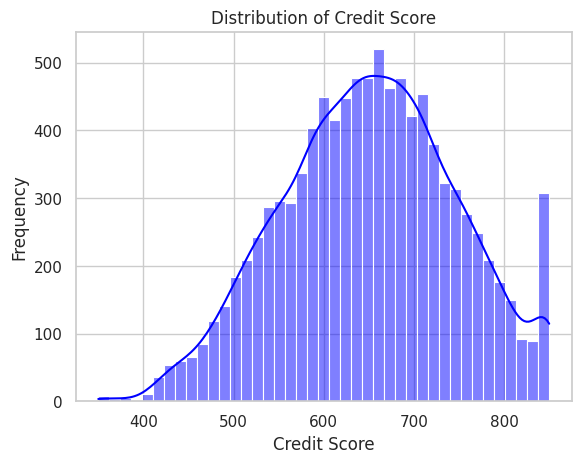

In [181]:
sns.histplot(data_cleaned['CreditScore'], kde=True, color='blue')
plt.title('Distribution of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

**Terlihat pada histrogram simetris bahwa persebaran pada credit skor memiliki profil kredit yang baik yang ditunjukan menyerupai distribusi normal**

### **Apakah peluang pergantian karyawan pada bank ini sanggat besar?**

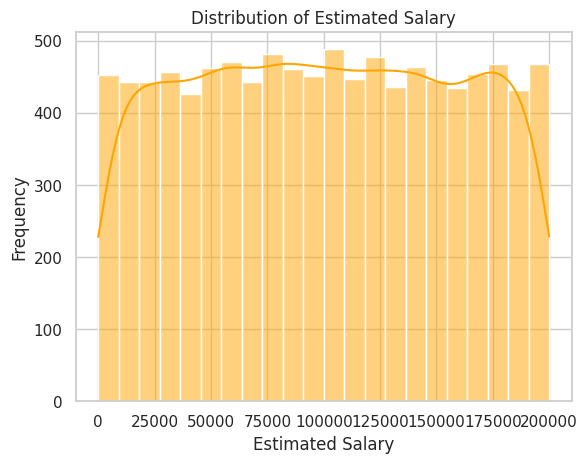

In [182]:
sns.histplot(data_cleaned['EstimatedSalary'], kde=True, color='orange')
plt.title('Distribution of Estimated Salary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')
plt.show()

**Pada histogram ini menandakan bahwa distribusi seragam pada gaji sehingga peluang pergantian karyawan sangat kecil**

### **Berapa banyak nasabah yang meninggalkan bank?**

,count
Exited,
0,7963
1,2037


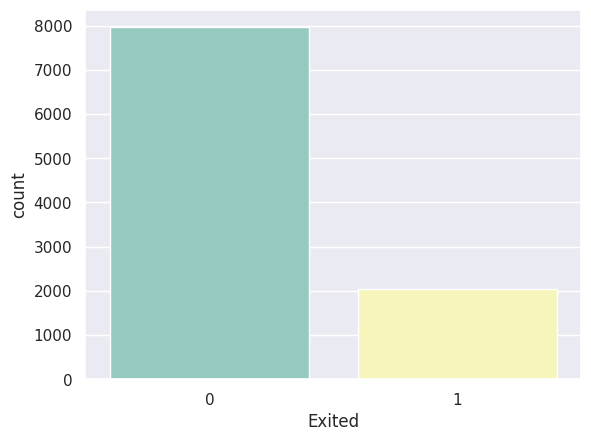

In [183]:
sns.set(style='darkgrid')
ax = sns.countplot(x='Exited', data=data_cleaned, palette='Set3')
data_cleaned.loc[:,'Exited'].value_counts()

**Sebanyak 7963 orang yang tidak meninggalkan bank, dan 2037 orang meninggalkan bank**

### **Apakah ada korelasi antara umur dan kemungkinan churn?**

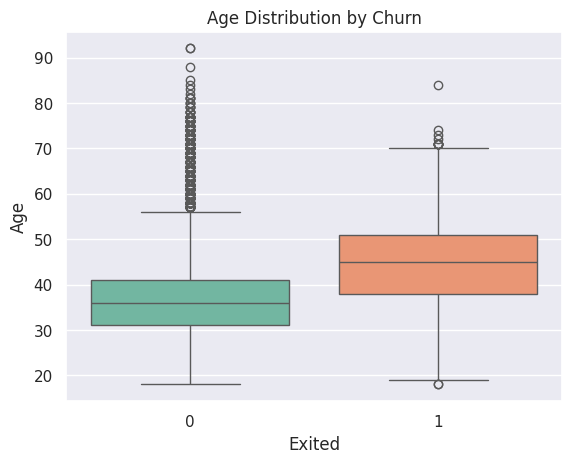

In [184]:
sns.boxplot(x='Exited', y='Age', data=data_cleaned, palette='Set2')
plt.title('Age Distribution by Churn')
plt.xlabel('Exited')
plt.ylabel('Age')
plt.show()

**Usia memiliki korelasi positif terhadap pelanggan yang melakukan churn, di mana churn cenderung memiliki usia lebih tua dibandingkan pelanggan yang tetap bertahan**

## **2. Model SVM**

**Data Preparation**

In [185]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data and standardize as before
X = data_cleaned.drop('Exited', axis=1)
y = data_cleaned['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Tuning dan Train SVM Model**

In [186]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Parameter grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale'],
    'class_weight': ['balanced']  # To handle the class imbalance
}

# Initialize the SVM model
svm = SVC(random_state=42)

# Setup GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Train the model with Grid Search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set using the best model
y_pred_best = best_model.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


## **3. Model Evaluation**

Accuracy: 0.7693333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84      2416
           1       0.44      0.74      0.55       584

    accuracy                           0.77      3000
   macro avg       0.68      0.76      0.70      3000
weighted avg       0.83      0.77      0.79      3000


Confusion Matrix:
 [[1878  538]
 [ 154  430]]


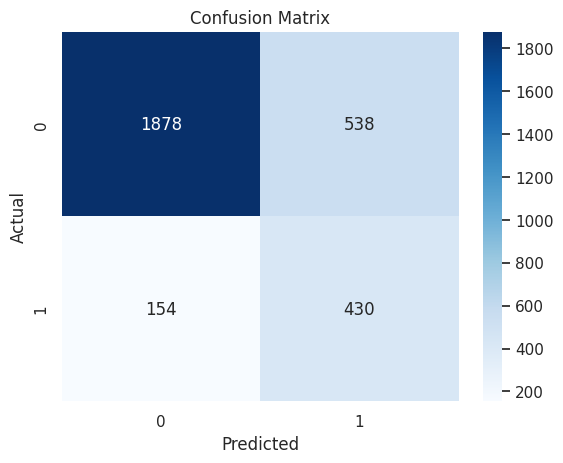

In [187]:
# Evaluate the best model
#display matrix

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1. Akurasi Keseluruhan

Akurasi: 0.769 (atau 76,9%)

Ini berarti bahwa model berhasil mengklasifikasikan 76,9% sampel uji dengan benar. Meskipun akurasi memberikan gambaran tentang seberapa sering model benar, akurasi saja tidak cukup untuk menilai performa pada dataset yang tidak seimbang seperti ini, di mana jumlah pelanggan yang tidak churn (kelas 0) lebih banyak dibandingkan dengan pelanggan yang churn (kelas 1).

2. Laporan Klasifikasi

Laporan klasifikasi memberikan metrik precision, recall, dan F1-score untuk setiap kelas.
Kelas 0 (Pelanggan yang tidak churn)

Precision (0.92):

Dari semua prediksi pelanggan yang tidak churn, 92% di antaranya benar-benar tidak churn. Precision yang tinggi ini menunjukkan bahwa model sangat akurat ketika memprediksi pelanggan yang tidak akan churn.

Recall (0.78):

Model berhasil mengidentifikasi 78% pelanggan yang benar-benar tidak churn. Beberapa pelanggan yang tidak churn salah diklasifikasikan sebagai churn.

F1-Score (0.84):

Skor ini menggabungkan precision dan recall menjadi satu metrik, menunjukkan bahwa model berfungsi cukup baik untuk kelas non-churn.
Kelas 1 (Pelanggan yang churn)

Precision (0.44):

Dari semua prediksi pelanggan yang churn, hanya 44% yang benar-benar churn. Precision yang rendah ini menunjukkan bahwa model memiliki tingkat false positive yang tinggi saat memprediksi churn.

Recall (0.74):

Model berhasil mengidentifikasi 74% pelanggan yang benar-benar churn. Ini adalah nilai recall yang kuat, yang berarti model berhasil menangkap sebagian besar pelanggan yang churn.

F1-Score (0.55):

Nilai F1-score ini lebih rendah dibandingkan dengan kelas 0, mencerminkan adanya keseimbangan antara precision dan recall untuk pelanggan yang churn.

3. Matriks Kebingungan (Confusion Matrix)

Matriks kebingungan memberikan rincian jumlah prediksi benar dan salah pada setiap kelas:

True Negatives (TN = 1878):

Model berhasil mengklasifikasikan 1.878 pelanggan yang tidak churn sebagai tidak churn.

False Positives (FP = 538):

Model salah memprediksi 538 pelanggan yang tidak churn sebagai churn.

False Negatives (FN = 154):

Model salah memprediksi 154 pelanggan yang churn sebagai tidak churn.

True Positives (TP = 430): Model berhasil mengidentifikasi 430 pelanggan yang benar-benar churn.


Ringkasan
Kekuatan:

Model cukup baik dalam mengidentifikasi pelanggan yang tidak churn (Kelas 0) dengan precision dan recall yang tinggi.
Tantangan:

Precision untuk pelanggan yang churn (Kelas 1) lebih rendah, yang berarti beberapa pelanggan salah diklasifikasikan sebagai churn padahal sebenarnya tidak. Namun, nilai recall untuk pelanggan churn cukup kuat, yang positif karena model berhasil menangkap sebagian besar pelanggan yang churn.

## **4. Analisis dan Insight Model**

In [188]:
# Predict churn status on the test set using the best model
y_pred_best = best_model.predict(X_test)


In [189]:
# Select the CustomerId from the original data that corresponds to the test set
customer_ids_test = data.loc[y_test.index, 'CustomerId']

# Create a DataFrame to show CustomerId, actual, and predicted churn status
classification_results = pd.DataFrame({
    'CustomerId': customer_ids_test,
    'Actual': y_test,
    'Predicted': y_pred_best
})

# Display the first few rows
classification_results.head()


,CustomerId,Actual,Predicted
6252,15687492,0,0
4684,15736963,0,0
1731,15721730,0,0
4742,15762134,0,1
4521,15648898,0,0


In [190]:
# Filter for customers predicted to churn
churned_customers = classification_results[classification_results['Predicted'] == 1]
churned_customers.head()


,CustomerId,Actual,Predicted
4742,15762134,0,1
6363,15593454,0,1
439,15690134,0,1
2750,15767474,1,1
7487,15785367,1,1


In [191]:
# Filter for customers predicted not to churn
non_churned_customers = classification_results[classification_results['Predicted'] == 0]
non_churned_customers.head()


,CustomerId,Actual,Predicted
6252,15687492,0,0
4684,15736963,0,0
1731,15721730,0,0
4521,15648898,0,0
6340,15659064,0,0
